In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

There are 2 datasets with infromation about users' activity during their online courses and status of their answers. In total there was 198 exercises ('steps') in this course, in order to get a certificate a user would have to pass 170 steps or more. We need to predict whether a user would drop a course or would finish it based on their early behavior.

#### Exploratory analysis and construction of target feature

In [2]:
event_data = pd.read_csv('event_data_train.csv')

In [3]:
submission_data = pd.read_csv('submissions_data_train.csv')

In [4]:
event_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [5]:
event_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [6]:
# I am going to add a date based on timestamp
event_data['date'] = pd.to_datetime(event_data.timestamp, unit='s')

In [7]:
event_data.date.max() 

Timestamp('2018-05-19 23:33:31')

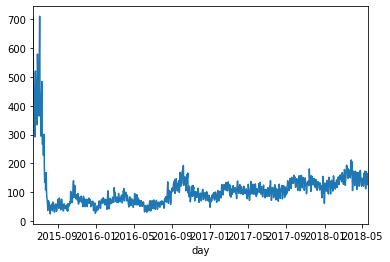

In [8]:
# let's see how many users were learning with this course per day
event_data['day'] = event_data.date.dt.date
event_data.groupby('day').user_id.nunique().plot()

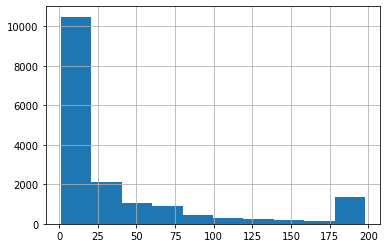

In [9]:
# the number of steps passed by users groups (here it seems that most of the users passed around 20 steps out of 198)
event_data[event_data.action == 'passed'].groupby('user_id', as_index=False)['step_id'].count()\
.rename(columns={'step_id': 'passed_steps'}).passed_steps.hist()

In [10]:
# here we see how many steps were discovered, passed, started_attempt or viewed by a user
users_event_data = event_data.pivot_table(index = 'user_id', columns = 'action', values = 'step_id', aggfunc='count', fill_value = 0)\
.reset_index()
users_event_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [11]:
# check out the other data
submission_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [12]:
# let's add date based on timestamp
submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit='s')
submission_data['day'] = pd.to_datetime(submission_data.date.dt.date)
submission_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [13]:
# here I count how many times a user submitted correct and wrong answers
users_score = submission_data.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count',\
                           fill_value=0).reset_index()
users_score.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [14]:
# we need to decide when a user might be considered as a drop out. 
#To do so first I am going to check how much time passed since their last visit. 

gap_data = event_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
.groupby('user_id')['timestamp'].apply(list).apply(np.diff).values
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24*60*60) # to convert time to days

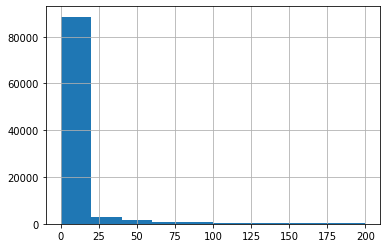

In [15]:
gap_data[gap_data<200].hist()

In [16]:
# seems like the gap between visits for the most people are around 20 days.
print(gap_data.quantile(0.95))
print(gap_data.quantile(0.90))

59.760440972222156
18.325995370370403


In [17]:
# I am going to set a treshold at 30 days, which is between 90 and 95 percentile, so the users who have been absent 
# for 30 days or more are considered to be droup outs 
users_data = event_data.groupby('user_id', as_index=False).timestamp.max().rename(columns={'timestamp': 'last_timestamp'})
now = 1526772811 # the last timestamp avaliable in our data
drop_out_threshold = 30*24*60*60
users_data['drop_out_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [18]:
# here I add info about correct and wrong submissions of users
users_data = users_data.merge(users_score, on='user_id', how='outer')
users_data = users_data.fillna(0)
# here I add how many steps were discovered, passed, started_attempt or viewed by a user
users_data = users_data.merge(users_event_data, how='outer') 

In [19]:
# how many days a user was at the course
users_day = event_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_day, how = 'outer')
users_data.head()

,user_id,last_timestamp,drop_out_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [20]:
# little chek up to make sure I didn't lose any data during merges
print(users_data.user_id.nunique())
print(event_data.user_id.nunique())

19234
19234


In [21]:
# we have to account for those users who finished the course. They would have to complete at least 170 steps.
users_data['passed_course'] = users_data.passed > 170

In [22]:
users_data.head()

,user_id,last_timestamp,drop_out_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [23]:
# how many users passed the course 
users_data.groupby('passed_course').user_id.count()

passed_course
False    17809
True      1425
Name: user_id, dtype: int64

In [24]:
100 * 1425/17809 # around 8% of users finished the course

8.001572238755685

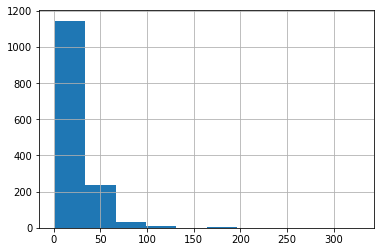

In [25]:
# how much time doest it usually take for a user to finish the course
users_data[users_data.passed_course == True].day.hist()

In [26]:
users_data[users_data.passed_course == True].day.median()

20.0

In [27]:
# here we add a new column with the fisrt time user visited the course into the df
user_min_time = event_data.groupby('user_id', as_index=False).timestamp.min()\
                .rename({'timestamp': 'min_timestamp'}, axis=1)
users_data = users_data.merge(user_min_time, how='outer')
users_data.head()

,user_id,last_timestamp,drop_out_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [28]:
# here we limit data so we only have users' activity for the first 3 days. 
# first we just concatenate user_id and timestamp
event_data['user_time'] = event_data['user_id'].map(str) + '_' + event_data['timestamp'].map(str)
learning_time_treshold = 3*24*60*60
user_learning_time_treshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_treshold)\
                              .map(str)

In [29]:
# user_learning_time_treshold shows us the last timestamp that we going to consider for each user + user's id
# in user_min_time we have min and max time we will use
user_min_time['user_learning_time_treshold'] = user_learning_time_treshold

In [30]:
event_data = event_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')

In [32]:
# df with users' activities between their first timestamp and their forth day 
event_data_train = event_data[event_data.user_time <= event_data.user_learning_time_treshold]

In [33]:
# check up to make sure everything went as planned. 
event_data_train.groupby('user_id').day.nunique().max()

4

In [34]:
# do the same for submission data
submission_data['users_time'] = submission_data.user_id.map(str) + '_' + submission_data.timestamp.map(str)
submission_data = submission_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
submission_data_train = submission_data[submission_data.users_time <= submission_data.user_learning_time_treshold]
submission_data_train.groupby('user_id').day.nunique().max()

4

In [35]:
submission_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,users_time,user_learning_time_treshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434605177
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,15853_1434348188,15853_1434605177
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,15853_1434347371,15853_1434605177


#### Assemble of the dataset we're going to use for ML and check if 3 days is enough to predict whether a user would drop out or not

In [36]:
X = submission_data_train.groupby('user_id').day.nunique().to_frame().reset_index()\
              .rename(columns={'day': 'days'})

In [37]:
steps_tried = submission_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
              .rename(columns={'step_id': 'step_tried'})

In [38]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [39]:
X = X.merge(submission_data_train.pivot_table(index='user_id', 
                                  columns='submission_status', 
                                  values='step_id', 
                                  aggfunc='count',
                                  fill_value=0).reset_index())

In [40]:
X['correct_ratio'] = X.correct/ (X.correct + X.wrong)

In [41]:
X = X.merge(event_data.pivot_table(index = 'user_id', 
                                          columns = 'action', 
                                          values = 'step_id', 
                                          aggfunc='count', 
                                          fill_value = 0).reset_index()[['user_id', 'viewed']], how='outer')

In [42]:
X = X.fillna(0)

In [43]:
X = X.merge(users_data[['user_id', 'passed_course', 'drop_out_user']], how='outer')

In [44]:
X.head()

,user_id,days,step_tried,correct,wrong,correct_ratio,viewed,passed_course,drop_out_user
0,2,1.0,2.0,2.0,0.0,1.00,10,False,True
1,3,1.0,4.0,4.0,4.0,0.50,192,False,True
2,8,1.0,11.0,9.0,21.0,0.30,156,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,651,True,True


In [45]:
# account for users who haven't finished the course yet, but also cannot be considered as droup outs
X = X[~((X.drop_out_user == False) & (X.passed_course == False))]

In [46]:
y = X.passed_course.map(int)

In [47]:
X = X.drop(['passed_course', 'drop_out_user'], axis=1)

In [48]:
X = X.set_index(X.user_id)
X = X.drop(['user_id'], axis=1)

In [49]:
X.head()

,days,step_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,10
3,1.0,4.0,4.0,4.0,0.50,192
8,1.0,11.0,9.0,21.0,0.30,156
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,651


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 17)

#### The number of features is small, I'll use Random Forest Classifier and roc_auc as a quality metric. 

In [51]:
rfc = RandomForestClassifier(random_state=17)

In [52]:
params = {'max_depth': [1, 2, 3, 5, 8, 10, 12, 15, 17, 20, 25, 50],
         'n_estimators': [50, 100, 150, 200, 250, 300]}

In [53]:
gs = GridSearchCV(rfc, params, cv=3, scoring = 'roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_params_, gs.best_score_)

{'max_depth': 5, 'n_estimators': 200} 0.9860420120436117


In [54]:
best_rfc = gs.best_estimator_

In [55]:
print('ROC AUC for the train set is %0.3f' %roc_auc_score(y_train, best_rfc.predict(X_train)))
print('ROC AUC for the test set is %0.3f' %roc_auc_score(y_test, best_rfc.predict(X_test)))

ROC AUC for the train set is 0.930
ROC AUC for the test set is 0.926


In [56]:
rfc_prob = best_rfc.predict_proba(X_test)
random_prob = [0 for _ in range(len(y_test))] #generate a no skill prediction (majority class)

In [57]:
pos_prob = rfc_prob[:, 1]
fpr, tpr, _ = roc_curve(y_test, pos_prob)
rfpr, rtpr, _ = roc_curve(y_test, random_prob)

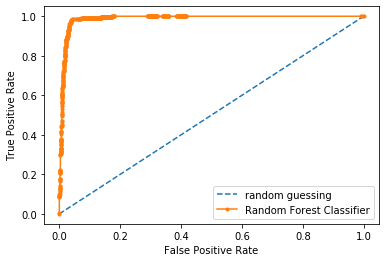

In [58]:
plt.plot(rfpr, rtpr, linestyle='--', label='random guessing')
plt.plot(fpr, tpr, marker='.', label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Roc_auc is 0.926 for test set and 0.930 for train set. It seems that the model can quite accurately predict drop outs based on a few first days of their activities.